<a href="https://colab.research.google.com/github/aneveu23/WSABI-Best-Ball-Draft-Wizard/blob/main/Eric_gamescore_ppr_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nfl_data_py
!python3 -m pip install pystan
!pip3 install nest_asyncio


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.0 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13188 sha256=54c23b9695b486daba126ddffe554f8a801a733b10ee1a16d3067fa5184a9cde
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 2.8 MB/s eta 0:00:00


In [ ]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stan
import nest_asyncio
import seaborn as sns


In [ ]:
drive.mount('drive')

ValueError: mount failed

In [ ]:
data = nfl.import_weekly_data([2021, 2022, 2023], columns = ['player_display_name', 'position', 'fantasy_points_ppr', 'week', 'season', 'recent_team', 'opponent_team'])
data.columns = ['player', 'position', 'ppr', 'week', 'season', 'team', 'opponent_team']
data = data[(data['week'] <= 18)]
data.head()

Downcasting floats.


,player,position,ppr,week,season,team,opponent_team
0,Tom Brady,QB,27.160000,1,2021,TB,DAL
1,Tom Brady,QB,29.639999,2,2021,TB,ATL
2,Tom Brady,QB,28.680000,3,2021,TB,LA
3,Tom Brady,QB,11.060000,4,2021,TB,NE
4,Tom Brady,QB,37.740002,5,2021,TB,MIA


In [ ]:
games = nfl.import_schedules([2021, 2022, 2023])
games = games.loc[:,['season', 'week', 'home_team', 'home_score', 'away_team', 'away_score']]
games = games.sort_values(['home_team', 'season', 'week'])
games.head()

,season,week,home_team,home_score,away_team,away_score
5878,2021,2,ARI,34.0,MIN,33.0
5928,2021,5,ARI,17.0,SF,10.0
5955,2021,7,ARI,31.0,HOU,5.0
5959,2021,8,ARI,21.0,GB,24.0
5996,2021,10,ARI,10.0,CAR,34.0


Get play type distribution and run%

In [ ]:
plays = nfl.import_pbp_data([2021, 2022, 2023])

2021 done.
2022 done.
2023 done.
Downcasting floats.


In [ ]:
plays['play_type'].unique()

array([None, 'kickoff', 'run', 'pass', 'punt', 'no_play', 'field_goal',
       'extra_point', 'qb_spike', 'qb_kneel'], dtype=object)

In [ ]:
plays = plays.loc[:,['season', 'week', 'posteam', 'defteam', 'play_type']]
play_type_counts = plays.groupby(['season', 'posteam'])['play_type'].value_counts().unstack(fill_value=0)
play_type_counts = play_type_counts.sort_values(['posteam', 'season'])
play_type_counts = play_type_counts.reindex(columns = ['run', 'pass', 'punt', 'kickoff', 'field_goal', 'extra_point', 'qb_spike', 'qb_kneel', 'no_play'])
play_type_counts['run%'] = np.zeros(len(play_type_counts))

for i in range(len(play_type_counts)):
    play_type_counts.iloc[i, -1] = (play_type_counts.iloc[i, 0]) / (play_type_counts.iloc[i, 0] + play_type_counts.iloc[i, 1])
play_type_counts = play_type_counts.reset_index()

In [ ]:
play_type_counts.head()

play_type,season,posteam,run,pass,punt,kickoff,field_goal,extra_point,qb_spike,qb_kneel,no_play,run%
0,2021,ARI,497,669,57,86,38,49,0,17,89,0.426244
1,2022,ARI,429,713,68,94,32,27,4,7,83,0.375657
2,2023,ARI,469,602,64,94,33,23,1,8,90,0.437908
3,2021,ATL,384,614,66,97,29,30,1,10,80,0.384770
4,2022,ATL,550,450,62,91,37,35,4,10,61,0.550000


In [ ]:
play_type_counts.head(50)

,play_type,run,pass,punt,kickoff,field_goal,extra_point,qb_spike,qb_kneel,no_play,run%
season,posteam,,,,,,,,,,
2021,ARI,497,669,57,86,38,49,0,17,89,0.426244
2022,ARI,429,713,68,94,32,27,4,7,83,0.375657
2023,ARI,469,602,64,94,33,23,1,8,90,0.437908
2021,ATL,384,614,66,97,29,30,1,10,80,0.384770
2022,ATL,550,450,62,91,37,35,4,10,61,0.550000
2023,ATL,514,569,75,91,37,28,4,9,68,0.474608
2021,BAL,509,668,71,85,37,32,7,9,78,0.432455
2022,BAL,543,553,60,81,44,34,5,19,65,0.495438
2023,BAL,586,601,76,81,40,57,1,14,86,0.493682


In [ ]:
player_seasons = data.groupby(['player', 'season', 'position', 'team'])['ppr'].sum().reset_index()
player_seasons

,player,season,position,team,ppr
0,A.J. Brown,2021,WR,TEN,180.899994
1,A.J. Brown,2022,WR,PHI,299.600006
2,A.J. Brown,2023,WR,PHI,289.600006
3,A.J. Dillon,2021,RB,GB,185.599991
4,A.J. Dillon,2022,RB,GB,167.600006
...,...,...,...,...,...
1915,Zay Jones,2021,WR,LV,105.900002
1916,Zay Jones,2022,WR,JAX,198.100006
1917,Zay Jones,2023,WR,JAX,78.099998
1918,Zonovan Knight,2022,RB,NYJ,59.000000


In [ ]:
# helper function to get 2nd highest value in each group
def get_second_largest(group):
    return group.nlargest(2, 'ppr').iloc[1]

Get individual dataframes for each position

In [ ]:
qb = data[(data['position'] == 'QB')].sort_values(by = ['team', 'season', 'week'])
rb = data[(data['position'] == 'RB')].sort_values(by = ['team', 'season', 'week'])
wr = data[(data['position'] == 'WR')].sort_values(by = ['team', 'season', 'week'])
te = data[(data['position'] == 'TE')].sort_values(by = ['team', 'season', 'week'])

Get season-level dataframes of the best/2nd best player at a position on each team

In [ ]:
qbs = player_seasons[(player_seasons)['position'] == 'QB'].sort_values(by = ['team', 'season'])
idx = qbs.groupby(['team', 'season'])['ppr'].idxmax()
qbs = qbs.loc[idx]

rb1s = player_seasons[(player_seasons)['position'] == 'RB'].sort_values(by = ['team', 'season'])
idx = rb1s.groupby(['team', 'season'])['ppr'].idxmax()
rb1s = rb1s.loc[idx]

rb2s = player_seasons[(player_seasons)['position'] == 'RB'].sort_values(by = ['team', 'season'])
rb2s = rb2s.groupby(['team', 'season']).apply(get_second_largest).reset_index(drop = True)

wr1s = player_seasons[(player_seasons)['position'] == 'WR'].sort_values(by = ['team', 'season'])
idx = wr1s.groupby(['team', 'season'])['ppr'].idxmax()
wr1s = wr1s.loc[idx]

wr2s = player_seasons[(player_seasons)['position'] == 'WR'].sort_values(by = ['team', 'season'])
wr2s = wr2s.groupby(['team', 'season']).apply(get_second_largest).reset_index(drop = True)

tes = player_seasons[(player_seasons)['position'] == 'TE'].sort_values(by = ['team', 'season'])
idx = tes.groupby(['team', 'season'])['ppr'].idxmax()
tes = tes.loc[idx]

Get week-level dataframes for each position

In [ ]:
qb = pd.merge(qb, qbs, on = ['player', 'team', 'season'], how = 'inner')
rb1 = pd.merge(rb, rb1s, on = ['player', 'team', 'season'], how = 'inner')
rb2 = pd.merge(rb, rb2s, on = ['player', 'team', 'season'], how = 'inner')
wr1 = pd.merge(wr, wr1s, on = ['player', 'team', 'season'], how = 'inner')
wr2 = pd.merge(wr, wr2s, on = ['player', 'team', 'season'], how = 'inner')
te = pd.merge(te, tes, on = ['player', 'team', 'season'], how = 'inner')

Get matchup dataframe

In [ ]:
matchups = data[['season', 'week', 'team', 'opponent_team']].drop_duplicates().sort_values(['team', 'season', 'week'])

print(len(matchups))
matchups = matchups.drop(matchups[matchups['team'] == matchups['opponent_team']].index)
print(len(matchups))

matchups['team_score'] = np.zeros(len(matchups))
matchups['opp_score'] = np.zeros(len(matchups))

for i in range(len(matchups)):
    game_row = games[(games['week'] == matchups.iloc[i, 1]) & (games['season'] == matchups.iloc[i, 0]) &
                              ((games['home_team'] == matchups.iloc[i, 2]) | (games['home_team'] == matchups.iloc[i, 3]))]
    matchups.iloc[i, 4] = game_row.iloc[0, 3]
    matchups.iloc[i, 5] = game_row.iloc[0, 5]



1653
1629


In [ ]:
position_df_data = {
    'season' : [],
    'week' : [],
    'team' : [],
    'opponent_team' : [],
    'qb' : [],
    'rb1' : [],
    'rb2' : [],
    'wr1' : [],
    'wr2' : [],
    'te' : [],
    'opp_qb' : [],
    'opp_rb1' : [],
    'opp_rb2' : [],
    'opp_wr1' : [],
    'opp_wr2' : [],
    'opp_te' : [],
    'team_score' : [],
    'opp_score' : [],
    'total_ppr' : [],
    'opp_total_ppr' : [],
    'run_pct' : [],
    'opp_run_pct' : []
}

position_df = pd.DataFrame(position_df_data)

In [ ]:
teams = matchups['team'].unique()

In [ ]:
for season in range(2021,2024):
  for team in range(32):
    for week in range(18):

      # get team points for each position-week
      qb_row = qb[(qb['season'] == season) & (qb['team'] == teams[team]) & (qb['week'] == week+1)]
      rb1_row = rb1[(rb1['season'] == season) & (rb1['team'] == teams[team]) & (rb1['week'] == week+1)]
      rb2_row = rb2[(rb2['season'] == season) & (rb2['team'] == teams[team]) & (rb2['week'] == week+1)]
      wr1_row = wr1[(wr1['season'] == season) & (wr1['team'] == teams[team]) & (wr1['week'] == week+1)]
      wr2_row = wr2[(wr2['season'] == season) & (wr2['team'] == teams[team]) & (wr2['week'] == week+1)]
      te_row = te[(te['season'] == season) & (te['team'] == teams[team]) & (te['week'] == week+1)]

      qb_ppr = 0 if (qb_row.empty) else qb_row.iloc[0, 2]
      rb1_ppr = 0 if (rb1_row.empty) else rb1_row.iloc[0, 2]
      rb2_ppr = 0 if (rb2_row.empty) else rb2_row.iloc[0, 2]
      wr1_ppr = 0 if (wr1_row.empty) else wr1_row.iloc[0, 2]
      wr2_ppr = 0 if (wr2_row.empty) else wr2_row.iloc[0, 2]
      te_ppr = 0 if (te_row.empty) else te_row.iloc[0, 2]

      # get opposing team points
      matchup_row = matchups[(matchups['season'] == season) & (matchups['week'] == week+1) & (matchups['team'] == teams[team])]
      if (not matchup_row.empty):
        opponent = matchup_row.iloc[0, 3]
        curr_team = teams[team]

        opp_qb_row = qb[(qb['season'] == season) & (qb['team'] == opponent) & (qb['week'] == week+1)]
        opp_rb1_row = rb1[(rb1['season'] == season) & (rb1['team'] == opponent) & (rb1['week'] == week+1)]
        opp_rb2_row = rb2[(rb2['season'] == season) & (rb2['team'] == opponent) & (rb2['week'] == week+1)]
        opp_wr1_row = wr1[(wr1['season'] == season) & (wr1['team'] == opponent) & (wr1['week'] == week+1)]
        opp_wr2_row = wr2[(wr2['season'] == season) & (wr2['team'] == opponent) & (wr2['week'] == week+1)]
        opp_te_row = te[(te['season'] == season) & (te['team'] == opponent) & (te['week'] == week+1)]

        opp_qb_ppr = 0 if (opp_qb_row.empty) else opp_qb_row.iloc[0, 2]
        opp_rb1_ppr = 0 if (opp_rb1_row.empty) else opp_rb1_row.iloc[0, 2]
        opp_rb2_ppr = 0 if (opp_rb2_row.empty) else opp_rb2_row.iloc[0, 2]
        opp_wr1_ppr = 0 if (opp_wr1_row.empty) else opp_wr1_row.iloc[0, 2]
        opp_wr2_ppr = 0 if (opp_wr2_row.empty) else opp_wr2_row.iloc[0, 2]
        opp_te_ppr = 0 if (opp_te_row.empty) else opp_te_row.iloc[0, 2]

        team_score = matchup_row.iloc[0, 4]
        opp_score = matchup_row.iloc[0, 5]

        play_type_row = play_type_counts[(play_type_counts['season'] == season) & (play_type_counts['posteam'] == curr_team)]
        run_pct = play_type_row.iloc[0, -1]

        opp_play_type_row = play_type_counts[(play_type_counts['season'] == season) & (play_type_counts['posteam'] == opponent)]
        opp_run_pct = opp_play_type_row.iloc[0, -1]

        total_ppr = qb_ppr + rb1_ppr + rb2_ppr + wr1_ppr + wr2_ppr + te_ppr
        opp_total_ppr = opp_qb_ppr + opp_rb1_ppr + opp_rb2_ppr + opp_wr1_ppr + opp_wr2_ppr + opp_te_ppr

        new_row = {
          'season' : season,
          'week' : week+1,
          'team' : curr_team,
          'opponent_team' : opponent,
          'qb' : qb_ppr,
          'rb1' : rb1_ppr,
          'rb2' : rb2_ppr,
          'wr1' : wr1_ppr,
          'wr2' : wr2_ppr,
          'te' : te_ppr,
          'opp_qb' : opp_qb_ppr,
          'opp_rb1' : opp_rb1_ppr,
          'opp_rb2' : opp_rb2_ppr,
          'opp_wr1' : opp_wr1_ppr,
          'opp_wr2' : opp_wr2_ppr,
          'opp_te' : opp_te_ppr,
          'team_score' : team_score,
          'opp_score' : opp_score,
          'total_ppr' : total_ppr,
          'opp_total_ppr': opp_total_ppr,
          'run_pct' : run_pct,
          'opp_run_pct' : opp_run_pct
        }
        position_df.loc[len(position_df)] = new_row



In [ ]:
position_df

,season,week,team,opponent_team,qb,rb1,rb2,wr1,wr2,te,...,opp_rb2,opp_wr1,opp_wr2,opp_te,team_score,opp_score,total_ppr,opp_total_ppr,run_pct,opp_run_pct
0,2021,1,ARI,TEN,33.560001,5.300000,14.6,24.0,4.500000,0.0,...,0.000000,14.900000,2.000000,4.9,13.0,38.0,81.959999,46.680001,0.426244,0.482082
1,2021,2,ARI,MIN,33.099998,2.600000,12.5,9.5,13.400000,0.0,...,3.800000,18.500000,15.900000,3.5,34.0,33.0,71.099998,83.760002,0.426244,0.412639
2,2021,3,ARI,JAX,18.540001,18.299999,14.5,17.4,16.200001,0.0,...,0.000000,12.200000,8.800000,0.0,19.0,31.0,84.940002,53.860001,0.426244,0.376953
3,2021,4,ARI,LA,22.620001,20.600000,17.9,1.5,17.700001,0.0,...,-0.900000,11.400000,21.000000,7.6,20.0,37.0,80.320007,75.000000,0.426244,0.396486
4,2021,5,ARI,SF,13.660000,10.700000,4.4,10.0,2.300000,0.0,...,0.000000,16.100000,5.200000,0.0,17.0,10.0,41.060001,29.500000,0.426244,0.479097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,2023,13,WAS,MIA,19.180000,5.300000,11.2,0.0,10.500000,2.0,...,25.299999,32.299999,10.200000,0.0,15.0,45.0,48.180000,99.099991,0.336792,0.417352
1625,2023,15,WAS,LA,8.280000,0.000000,8.5,26.1,21.100000,1.7,...,1.600000,10.300000,25.100000,7.6,28.0,20.0,65.680001,87.619995,0.336792,0.426702
1626,2023,16,WAS,NYJ,-1.760000,0.000000,10.2,8.0,3.000000,14.6,...,0.000000,15.800000,2.700000,7.6,30.0,28.0,34.040000,69.199999,0.336792,0.367016
1627,2023,17,WAS,SF,6.660000,11.600000,5.6,16.1,6.300000,5.0,...,14.000000,24.400000,18.200001,5.9,10.0,27.0,51.259998,93.200005,0.336792,0.468960


In [ ]:
np.corrcoef(position_df[''], position_df[''])

array([[1.       , 0.4461364],
       [0.4461364, 1.       ]])

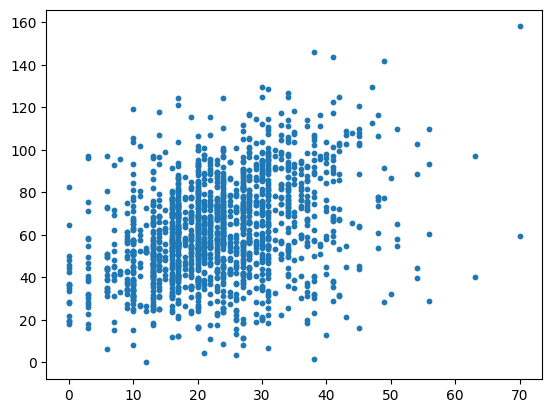

In [ ]:
plt.scatter(position_df['team_score'], position_df['total_ppr'], s = 10)
plt.show()

In [ ]:
normalized_df = position_df.copy()

In [ ]:
normalized_df.shape

(1629, 22)

In [ ]:
for i in range(4, normalized_df.shape[1]):
    col_mean = normalized_df.iloc[:, i].mean()
    col_sd = normalized_df.iloc[:, i].std()
    for j in range(normalized_df.shape[0]):
      normalized_df.iloc[j, i] = (normalized_df.iloc[j, i] - col_mean) / col_sd

In [ ]:
normalized_df.head()

,season,week,team,opponent_team,qb,rb1,rb2,wr1,wr2,te,...,opp_rb2,opp_wr1,opp_wr2,opp_te,team_score,opp_score,total_ppr,opp_total_ppr,run_pct,opp_run_pct
0,2021,1,ARI,TEN,2.102424,-0.783219,1.298340,1.121430,-0.547962,-1.092258,...,-0.922725,0.138650,-0.878734,-0.395273,-1.020555,1.748091,0.846521,-0.666653,0.426244,0.482082
1,2021,2,ARI,MIN,2.053591,-1.078708,0.978871,-0.443987,0.629319,-1.092258,...,-0.344640,0.527487,0.959928,-0.594157,1.064376,1.229319,0.380840,0.923724,0.426244,0.412639
2,2021,3,ARI,JAX,0.507922,0.639509,1.283127,0.408895,0.999699,-1.092258,...,-0.922725,-0.152978,0.020755,-1.091365,-0.424860,1.021811,0.974305,-0.358700,0.426244,0.376953
3,2021,4,ARI,LA,0.941049,0.891223,1.800361,-1.307666,1.198117,-1.092258,...,-1.059640,-0.239386,1.634544,-0.011712,-0.325578,1.644336,0.776198,0.548004,0.426244,0.396486
4,2021,5,ARI,SF,-0.010132,-0.192239,-0.253363,-0.390007,-0.838975,-1.092258,...,-0.922725,0.268262,-0.455445,-1.091365,-0.623425,-1.157029,-0.907286,-1.403510,0.426244,0.479097


In [ ]:
nest_asyncio.apply()

normalized_df = normalized_df.drop_duplicates()
normalized_df = normalized_df[(normalized_df['team'] != '')]

pre_stan_input = normalized_df[['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te', 'team_score', 'opp_score', 'total_ppr', 'opp_total_ppr', 'run_pct', 'opp_run_pct']]

In [ ]:
stan_input = pre_stan_input[['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te', 'team_score', 'opp_score', 'run_pct', 'opp_run_pct']]

In [ ]:
nest_asyncio.apply()

position_df = position_df.drop_duplicates()
position_df = position_df[(position_df['team'] != '')]

stan_input = position_df[['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te', 'team_score', 'opp_score', 'run_pct', 'opp_run_pct']]

In [ ]:
stan_input.shape

(1629, 16)

In [ ]:
mean = stan_input['run_pct'].mean()
sd = stan_input['run_pct'].std()
print(mean)
print(sd)

0.41897060076680076
0.04618982431460093


Stan model

In [ ]:
stan_input = stan_input.to_numpy()
print(stan_input.shape)


(1629, 16)


In [ ]:
merged_data = {
    'N': stan_input.shape[0],
    'K': stan_input.shape[1],
    'y': stan_input
}

Stan code (this took like 5x less time on R lmao)

In [ ]:
merged_data

{'N': 1629,
 'K': 14,
 'y': array([[ 2.10242426, -0.7832187 ,  1.29833977, ..., -0.39527295,
          0.84652141, -0.66665284],
        [ 2.05359099, -1.07870845,  0.97887147, ..., -0.5941565 ,
          0.3808404 ,  0.92372373],
        [ 0.50792182,  0.63950945,  1.28312694, ..., -1.09136535,
          0.9743051 , -0.35869969],
        ...,
        [-1.64709815, -1.36325409,  0.62897765, ..., -0.01171187,
         -1.2083066 ,  0.29923916],
        [-0.75324264, -0.09374268, -0.07080992, ..., -0.25321328,
         -0.46990645,  1.32860933],
        [-0.67256206, -0.21412742,  0.08131782, ...,  0.74120434,
         -0.82324056,  2.45062269]])}

In [ ]:
stan_code = """
  // Stan model to estimate correlations between QB, RB, WR1, WR2, and TE fantasy points
  data {
    int<lower=1> N;          // Number of observations (e.g., games or players)
    int<lower=1> K;          // Number of variables (e.g., QB, RB, WR1, WR2, TE)
    matrix[N, K] y;
  }

  parameters {
    vector[K] mu;            // Means of fantasy points for QB, RB, WR1, WR2, and TE
    vector<lower=0>[K] sigma; // Standard deviations for QB, RB, WR1, WR2, and TE
    corr_matrix[K] Rho;      // Correlation matrix for the variables
  }

  transformed parameters {
    cov_matrix[K] Sigma;     // Covariance matrix

    // Construct the covariance matrix from standard deviations and correlations
    Sigma = quad_form_diag(Rho, sigma);
  }

  model {
    // Priors for means
    for (i in 1:K){
      mu ~ normal(0, 1);
      sigma ~ normal(1, 0.5);
    }

    // Priors for correlations
    Rho ~ lkj_corr(2);       // LKJ prior for correlation matrix
    //print(Rho);

    // Likelihood: Multivariate normal distribution for observed data
    for (i in 1:N) {
      y[i] ~ multi_normal(mu, Sigma);
    }
  }


"""

In [ ]:
model = stan.build(stan_code, data = merged_data)
fit = model.sample(num_chains=1, num_samples=2000, num_warmup=1000)

Building...



Building: 101.4s, done.Messages from stanc:
Warning in '/tmp/httpstan_6njx1vsr/model_wuogtgxx.stan', line 30, column 4: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   3% (100/3000)
Sampling:   7% (200/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  33% (1001/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampli

In [ ]:
fit_vars.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu.1,mu.2,mu.3,...,Sigma.7.16,Sigma.8.16,Sigma.9.16,Sigma.10.16,Sigma.11.16,Sigma.12.16,Sigma.13.16,Sigma.14.16,Sigma.15.16,Sigma.16.16
count,2000.000000,2000.000000,2.000000e+03,2000.0,2000.0,2000.0,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-1877.256291,0.872314,2.915875e-01,4.0,15.0,0.0,1953.581316,0.000606,0.000005,0.001274,...,-0.003028,-0.002019,0.002269,-0.004644,-0.005491,-0.001178,-0.000776,-0.001314,-0.000036,0.002161
std,8.553259,0.111024,5.552503e-17,0.0,0.0,0.0,12.301453,0.025072,0.025104,0.024894,...,0.001138,0.001128,0.001125,0.001163,0.001100,0.001173,0.001152,0.001156,0.000053,0.000074
min,-1916.874880,0.385636,2.915875e-01,4.0,15.0,0.0,1915.470775,-0.081734,-0.103869,-0.080503,...,-0.006966,-0.006798,-0.001397,-0.008671,-0.009524,-0.005020,-0.004464,-0.006058,-0.000203,0.001934
25%,-1882.793155,0.806781,2.915875e-01,4.0,15.0,0.0,1945.120898,-0.016217,-0.016318,-0.015382,...,-0.003787,-0.002778,0.001539,-0.005396,-0.006238,-0.001977,-0.001565,-0.002082,-0.000071,0.002111


In [ ]:
fit_df = fit.to_frame()
fit_vars = fit_df.describe()

In [ ]:

#print(fit_vars)
n = stan_input.shape[1]
corr_mean = np.zeros(shape = (n, n))
corr_sd = np.zeros(shape = (n, n))


for i in range(n):
  for j in range(n):
    corr_mean[i,j] = fit_vars.iloc[1, 7 + 2*n + i*n + j]
    corr_sd[i,j] = fit_vars.iloc[2, 7 + 2*n + i*n + j]



In [ ]:
np.set_printoptions(edgeitems=14, linewidth = 400, precision=3, suppress = True)


In [ ]:
L = np.linalg.cholesky(corr_mean)
print(L)

[[ 1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.101  0.995  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.051 -0.176  0.983  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.337 -0.031 -0.029  0.941  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.279 -0.017 -0.029 -0.061  0.958  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.224 -0.021 -0.044 -0.068 -0.107  0.965  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.155  0.022  0.011 -0.007  0.073  0.029  0.984  0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.038 -0.039 -0.048 -0.033  0.016  0.02   0.097  0.992  0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.015 -0.04  -0.02  -0.019 -0.013 -0.018  0.051 -0.179  0.981  0.     0.     

In [ ]:
print(corr_mean)
print("\n\n")
print(corr_sd)

[[ 1.     0.101  0.051  0.337  0.279  0.224  0.155  0.038  0.015  0.046  0.112  0.055  0.273  0.339 -0.066 -0.037]
 [ 0.101  1.    -0.17   0.003  0.011  0.002  0.038 -0.035 -0.038 -0.016  0.03   0.031  0.13   0.183 -0.044 -0.061]
 [ 0.051 -0.17   1.    -0.006 -0.011 -0.028  0.015 -0.039 -0.012 -0.011 -0.007 -0.008  0.115  0.064  0.048  0.009]
 [ 0.337  0.003 -0.006  1.     0.038  0.013  0.045 -0.016 -0.011  0.047  0.007  0.067  0.177  0.17  -0.1    0.006]
 [ 0.279  0.011 -0.011  0.038  1.    -0.035  0.113  0.03  -0.005  0.007  0.115  0.059  0.155  0.178 -0.117  0.017]
 [ 0.224  0.002 -0.028  0.013 -0.035  1.     0.054  0.031 -0.01   0.067  0.059 -0.014  0.103  0.157 -0.026 -0.058]
 [ 0.155  0.038  0.015  0.045  0.113  0.054  1.     0.102  0.05   0.337  0.279  0.225  0.272  0.339 -0.039 -0.065]
 [ 0.038 -0.035 -0.039 -0.016  0.03   0.031  0.102  1.    -0.169  0.004  0.01   0.001  0.129  0.183 -0.061 -0.043]
 [ 0.015 -0.038 -0.012 -0.011 -0.005 -0.01   0.05  -0.169  1.    -0.007 -0.011 -

In [ ]:
print(L)
print(L_sd)

NameError: name 'L' is not defined

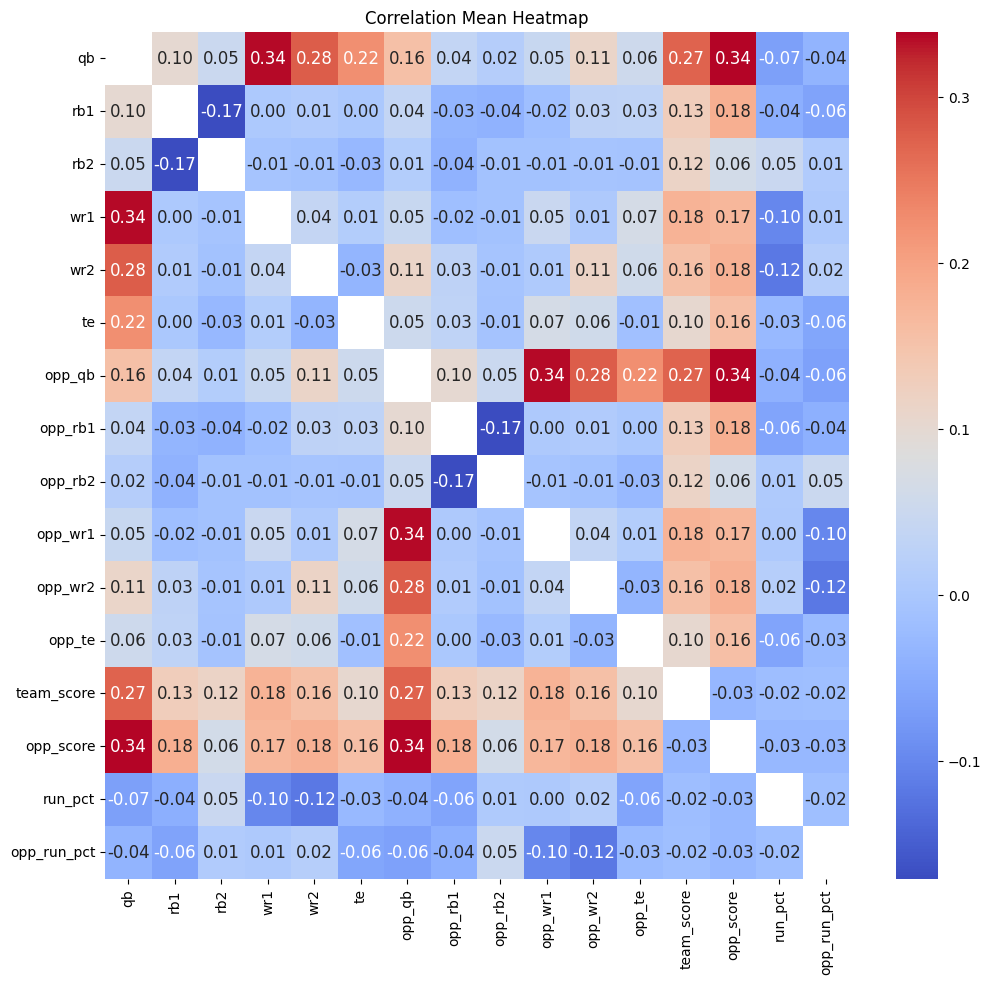

In [ ]:
plt.figure(figsize = (12, 11))

mask = np.eye(corr_mean.shape[0], dtype=bool)

row_names = pre_stan_input.columns
col_names = row_names

sns.heatmap(corr_mean, annot = True, cmap = 'coolwarm', fmt='.2f', annot_kws={'size': 12}, mask = mask, xticklabels = col_names, yticklabels = row_names)
plt.title("Correlation Mean Heatmap")
plt.show()

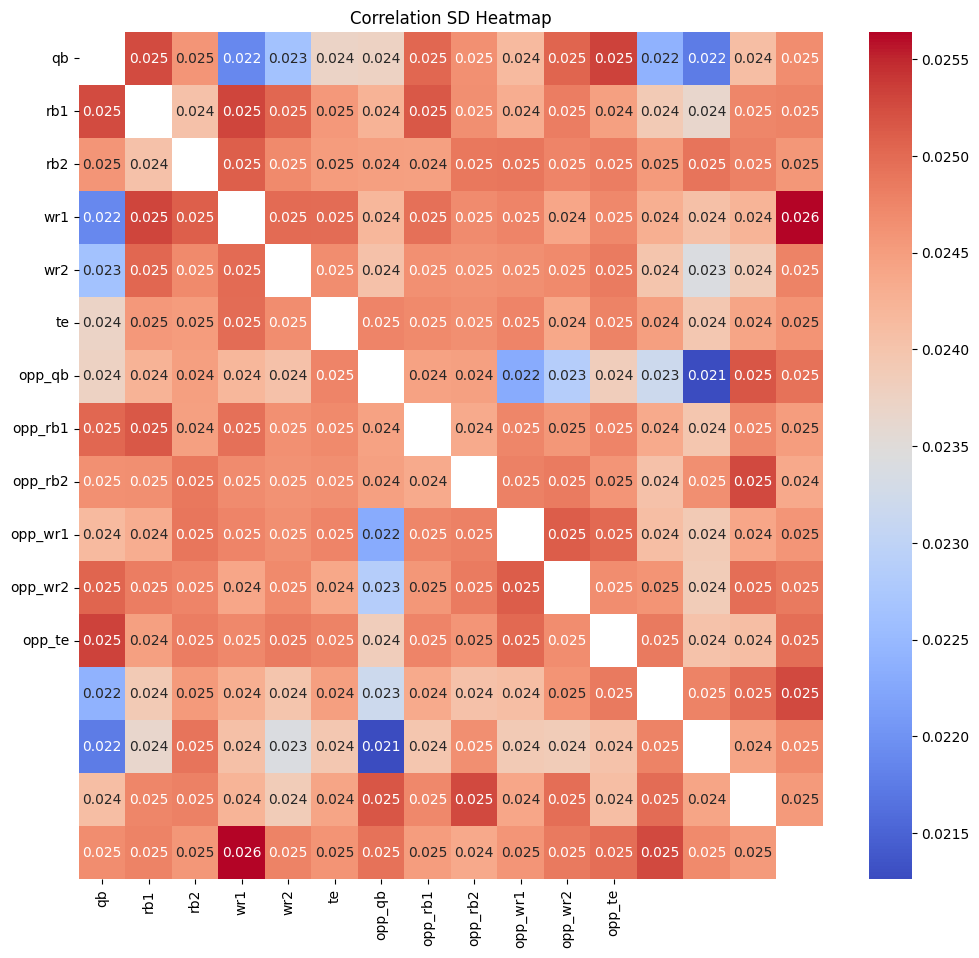

In [ ]:
plt.figure(figsize = (12, 11))

mask = np.eye(corr_sd.shape[0], dtype=bool)

row_names = ['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te']
col_names = row_names

sns.heatmap(corr_sd, annot = True, cmap = 'coolwarm', fmt='.3f', annot_kws={'size': 10}, mask = mask, xticklabels = col_names, yticklabels = row_names)
plt.title("Correlation SD Heatmap")
plt.show()

Shitty simulation

In [ ]:
qb_sims = np.random.gamma(3, position_df['qb'].mean()/3, 1000)
rb1_sims = np.random.gamma(3, position_df['rb1'].mean()/3, 1000)
rb2_sims = np.random.gamma(3, position_df['rb2'].mean()/3, 1000)
wr1_sims = np.random.gamma(3, position_df['wr1'].mean()/3, 1000)
wr2_sims = np.random.gamma(3, position_df['wr2'].mean()/3, 1000)
te_sims = np.random.gamma(3, position_df['te'].mean()/3, 1000)

opp_qb_sims = np.random.gamma(3, position_df['qb'].mean()/3, 1000)
opp_rb1_sims = np.random.gamma(3, position_df['rb1'].mean()/3, 1000)
opp_rb2_sims = np.random.gamma(3, position_df['rb2'].mean()/3, 1000)
opp_wr1_sims = np.random.gamma(3, position_df['wr1'].mean()/3, 1000)
opp_wr2_sims = np.random.gamma(3, position_df['wr2'].mean()/3, 1000)
opp_te_sims = np.random.gamma(3, position_df['te'].mean()/3, 1000)

score_sims = np.random.gamma(9, position_df['team_score'].mean()/9, 1000)
opp_score_sims = np.random.gamma(9, position_df['opp_score'].mean()/9, 1000)

run_pct_sims = np.random.normal(position_df['run_pct'].mean(), position_df['run_pct'].std()/4, 1000)
opp_run_pct_sims = np.random.normal(position_df['run_pct'].mean(), position_df['run_pct'].std()/4, 1000)


23.277267252234633

In [ ]:
sim = pd.DataFrame({
    'qb' : qb_sims,
    'rb1' : rb1_sims,
    'rb2' : rb2_sims,
    'wr1' : wr1_sims,
    'wr2' : wr2_sims,
    'te' : te_sims,
    'opp_qb' : opp_qb_sims,
    'opp_rb1' : opp_rb1_sims,
    'opp_rb2' : opp_rb2_sims,
    'opp_wr1' : opp_wr1_sims,
    'opp_wr2' : opp_wr2_sims,
    'opp_te' : opp_te_sims,
    'team_score' : score_sims,
    'opp_score' : opp_score_sims,
    'run_pct' : run_pct_sims,
    'opp_run_pct' : opp_run_pct_sims
})

In [ ]:
sim.head()

,qb,rb1,rb2,wr1,wr2,te,opp_qb,opp_rb1,opp_rb2,opp_wr1,opp_wr2,opp_te,team_score,opp_score,run_pct,opp_run_pct
0,21.537081,24.435145,5.584938,28.041491,1.803957,10.893674,3.183412,14.697095,5.544972,7.742673,7.930330,11.855771,19.596861,13.859229,0.431921,0.408053
1,12.307226,9.408012,7.096277,19.424981,28.321437,7.392678,19.865581,4.916062,3.831205,27.751881,9.172223,3.795771,18.784095,8.810995,0.403852,0.423491
2,17.139437,17.823382,4.381613,29.192200,6.567152,7.103343,3.798027,16.037586,7.767879,19.333911,1.057567,3.642024,12.505994,30.666061,0.407898,0.414036
3,32.985681,21.175800,1.418912,8.740352,4.733631,3.921561,17.228492,9.149586,7.903751,23.694845,9.378316,5.247058,21.903696,32.797605,0.416137,0.427611
4,13.040807,4.554366,2.221350,2.263928,7.770422,12.672811,3.801461,6.259529,12.924213,15.601188,6.493633,8.024033,17.746113,26.020901,0.401984,0.386408


In [ ]:
sim_matrix = np.asmatrix(sim)
sim_correlated = sim_matrix @ L.T

In [ ]:
sim_correlated

matrix([[21.537, 26.478,  2.29 , 32.718,  5.439, 12.483,  7.327, 13.777,  1.466,  9.611,  9.939, 13.339, 35.088, 25.048, -4.089, -2.806],
        [12.307, 10.598,  5.948, 21.924, 29.005,  5.026, 23.894,  6.493,  2.704, 33.568, 15.588,  7.982, 36.027, 21.455, -4.271, -3.291],
        [17.139, 19.457,  2.046, 32.557,  8.853,  7.442,  7.322, 15.278,  3.647, 20.319,  2.392,  5.37 , 27.914, 38.091, -3.399, -1.279],
        [32.986, 24.387, -0.65 , 18.644, 12.796,  9.561, 22.956, 10.946,  6.327, 28.979, 15.916,  8.628, 41.531, 44.311, -1.854, -3.739],
        [13.041,  5.843,  2.046,  6.32 , 10.8  , 13.97 ,  6.801,  7.077, 11.354, 16.565,  8.394,  7.219, 27.545, 27.676, -0.338, -0.971],
        [ 6.582, 15.798, 11.352, 17.524,  8.64 ,  6.04 , 34.276, 33.895, -0.612, 16.909, 18.824, 12.492, 50.217, 36.686, -2.332, -2.904],
        [ 7.902,  6.182,  1.758,  6.879,  5.06 , 10.132, 27.804, 16.877, 10.825, 15.607, 13.471, 16.192, 28.221, 24.178, -1.571, -2.559],
        [22.047,  7.677,  7.69 , 1

In [ ]:
sim_corr_df = pd.DataFrame(sim_correlated)
sim_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,21.537081,26.477752,2.289834,32.717954,5.439462,12.482788,7.326524,13.776612,1.465642,9.610757,9.938993,13.339073,35.087524,25.047712,-4.089144,-2.805990
1,12.307226,10.598355,5.948266,21.923598,29.004765,5.026391,23.893911,6.493211,2.703637,33.568327,15.587676,7.981925,36.026679,21.455388,-4.271488,-3.291498
2,17.139437,19.457140,2.045645,32.556820,8.853490,7.442000,7.321564,15.278299,3.647402,20.319186,2.391961,5.369916,27.914011,38.090599,-3.399135,-1.278588
3,32.985681,24.386633,-0.650434,18.643728,12.796314,9.560940,22.956352,10.945677,6.327083,28.979428,15.916166,8.627850,41.530968,44.311249,-1.853782,-3.738644
4,13.040807,5.843126,2.046377,6.320265,10.800323,13.969919,6.801299,7.076565,11.353636,16.565462,8.393643,7.219004,27.545255,27.676313,-0.337717,-0.970799


In [ ]:
for i in range(14):
  print(sim_corr_df[i].mean())
  print(position_df.iloc[:, i+4].mean())
  print("\n\n")

13.63793310536008
13.755445075856533



13.707804440843178
12.456562315387693



4.513813514795371
6.06546348024633



16.81113912827631
13.612523023352402



10.638471803020872
8.64248005498802



8.043375367328641
7.686065080763739



16.674970706949495
13.761669753783682



13.163854129413195
12.454168208807872



3.4692562439137906
6.06546348024633



18.023866109994298
13.616329039196026



12.803311826926272
8.643093928530071



10.014641807332366
7.682443226807099



36.50560015032184
23.279312461632905



27.337367916013175
21.151626764886434





In [ ]:
np.corrcoef(sim_corr_df[0], sim_corr_df[3])

array([[1.   , 0.349],
       [0.349, 1.   ]])